# Bibliotecas

In [1]:
import sys

sys.path.append('/eos/user/t/thenriqu/Dark_Matter/XGB_MLP_hhdm_analysis/')

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import hepherolib.analysis as ana
import tensorflow as tf
from tensorflow.keras.models import load_model

from hhdm_analysis.xgb.utils import model_performance, compute_purity_cutflow, compute_best_thr
from hhdm_analysis.utils import position, signal_label
from hhdm_analysis.fdeep import convert as convert_to_fdeep

# Disable GPUs
tf.config.set_visible_devices([], 'GPU')

ana.start()
plt.style.use("default")

2024-07-16 18:51:20.614571: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-16 18:51:20.837279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Configuração

In [2]:
period = '16'
year_style = 2016
dataset_year = "2016"
basedir = '/eos/user/t/thenriqu/Dark_Matter/Amostras/hhdmAnalysis_deepJet_Regions/datasets'

# Setup figure folders
dataset_name = basedir.split('/')[-2]
figures_path = f"./figures/{dataset_name}/{dataset_year}/machine_learning"
Path(figures_path).mkdir(parents=True, exist_ok=True)

# Data folder
data_path = f"./data/{dataset_name}/{dataset_year}"
Path(data_path).mkdir(parents=True, exist_ok=True)

# Setup models folders
models_path = f"./models/{dataset_name}/{dataset_year}"
Path(models_path).mkdir(parents=True, exist_ok=True)

# Lendo metadata

In [3]:
with open("/eos/user/t/thenriqu/Dark_Matter/metadata.json", "r") as f:
    metadata = json.load(f)

# Lendo dados e modelo

In [4]:
model_name = "MLP_multi_signal"
plot_label ="Multi-signal"

# Train and test data
X_train = pd.read_csv(f"{data_path}/{model_name}-train-data.csv")
X_test = pd.read_csv(f"{data_path}/{model_name}-test-data.csv")
W_train = X_train.pop("modelWeight").values
W_test = X_test.pop("modelWeight").values
Y_train = X_train.pop("Label").values
Y_test = X_test.pop("Label").values
evtWeight_train = X_train.pop("evtWeight").values
evtWeight_test = X_test.pop("evtWeight").values

# Model
features = ["LeadingLep_pt", "LepLep_deltaM", "LepLep_deltaR", "LepLep_pt", "MET_LepLep_Mt", "MET_LepLep_deltaPhi", "MET_pt", "MT2LL", "Nbjets", "TrailingLep_pt"]
model = load_model(f"{models_path}/{model_name}-checkpoint.h5")

In [5]:
X_train.head()

,LeadingLep_pt,LepLep_deltaM,LepLep_deltaR,LepLep_pt,MET_LepLep_Mt,MET_LepLep_deltaPhi,MET_pt,MT2LL,Nbjets,TrailingLep_pt
0,1.653660,1.107949,-1.680690,1.119131,0.822467,0.168413,-0.340549,-0.548092,0.553515,-0.983446
1,-0.494677,-1.647357,-1.462073,-0.474156,-0.450191,0.056111,-0.729573,-0.413091,-0.779361,-0.443250
2,1.057360,-1.381918,-2.026380,0.937880,-0.019988,-0.059179,-0.803802,-0.215629,-0.779361,-0.077973
3,-0.999687,-0.677801,-0.295181,-0.992264,-0.739658,-0.080318,-0.652554,-0.617234,-0.779361,-0.595544
4,-0.851280,-1.568578,-0.115283,-0.983579,-0.820527,1.011143,-0.807823,-0.839501,-0.779361,-0.868746


In [6]:
X_train[features].head()

,LeadingLep_pt,LepLep_deltaM,LepLep_deltaR,LepLep_pt,MET_LepLep_Mt,MET_LepLep_deltaPhi,MET_pt,MT2LL,Nbjets,TrailingLep_pt
0,1.653660,1.107949,-1.680690,1.119131,0.822467,0.168413,-0.340549,-0.548092,0.553515,-0.983446
1,-0.494677,-1.647357,-1.462073,-0.474156,-0.450191,0.056111,-0.729573,-0.413091,-0.779361,-0.443250
2,1.057360,-1.381918,-2.026380,0.937880,-0.019988,-0.059179,-0.803802,-0.215629,-0.779361,-0.077973
3,-0.999687,-0.677801,-0.295181,-0.992264,-0.739658,-0.080318,-0.652554,-0.617234,-0.779361,-0.595544
4,-0.851280,-1.568578,-0.115283,-0.983579,-0.820527,1.011143,-0.807823,-0.839501,-0.779361,-0.868746


# Predict (previsão) do treino e teste

In [7]:
# Train
Y_pred_train = model.predict(X_train[features],batch_size=256)
perf_train = model_performance(Y_train, Y_pred_train, n=1000)
ppv_train_cutflow = compute_purity_cutflow(perf_train.threshold, perf_train.fpr, perf_train.tpr, perf_train.ppv, perf_train.acc)
best_train_thr = compute_best_thr(perf_train.threshold, perf_train.tpr, perf_train.ppv)
ppv_train_cutflow.to_csv(f"{models_path}/{model_name}-ppv-train-cutflow.csv", index=False)

# Test
Y_pred_test = model.predict(X_test[features],batch_size=256)
perf_test = model_performance(Y_test, Y_pred_test, n=1000)
ppv_test_cutflow = compute_purity_cutflow(perf_test.threshold, perf_test.fpr, perf_test.tpr, perf_test.ppv, perf_test.acc)
best_test_thr = compute_best_thr(perf_test.threshold, perf_test.tpr, perf_test.ppv)
ppv_test_cutflow.to_csv(f"{models_path}/{model_name}-ppv-test-cutflow.csv", index=False)

2839/2839 [==============================] - 3s 1ms/step


In [8]:
print("Best thr:", best_train_thr)
display(ppv_train_cutflow)

Best thr: 0.992992992992993


,purity_cut,purity,threshold,efficiency,bkg_rejection,accuracy
0,0.100000,0.100496,0.041041,0.995912,0.339205,0.384527
1,0.200000,0.200236,0.277277,0.976910,0.710754,0.729123
2,0.300000,0.300141,0.609610,0.953221,0.835232,0.843375
3,0.400000,0.400100,0.845846,0.922255,0.897493,0.899202
4,0.500000,0.500534,0.950951,0.878985,0.934980,0.931115
5,0.600000,0.600455,0.985986,0.810054,0.960043,0.949692
6,0.700000,0.716261,0.995996,0.679827,0.980036,0.959318
7,0.800000,0.877900,0.998999,0.473829,0.995115,0.959139
8,0.900000,1.000000,1.000000,0.000179,1.000000,0.930999
9,0.661573,0.661573,0.992993,0.749337,0.971584,0.956246


In [9]:
print("Best thr:", best_test_thr)
display(ppv_test_cutflow)

Best thr: 0.991991991991992


,purity_cut,purity,threshold,efficiency,bkg_rejection,accuracy
0,0.100000,0.100467,0.041041,0.995274,0.339401,0.384666
1,0.200000,0.200043,0.279279,0.974777,0.711031,0.729234
2,0.300000,0.300244,0.611612,0.952823,0.835379,0.843484
3,0.400000,0.400500,0.844845,0.923652,0.897506,0.899311
4,0.500000,0.500857,0.950951,0.879905,0.934995,0.931193
5,0.600000,0.602292,0.985986,0.810018,0.960349,0.949974
6,0.700000,0.716686,0.995996,0.679474,0.980088,0.959341
7,0.800000,0.875181,0.998999,0.469752,0.995033,0.958781
8,0.900000,1.000000,1.000000,0.000219,1.000000,0.931000
9,0.649046,0.649046,0.991992,0.762622,0.969431,0.955158


# Preparando dados para o plot do discriminante

In [10]:
X_train["MLP_score_keras"] = Y_pred_train
X_test["MLP_score_keras"] = Y_pred_test
X_train["modelWeight"] = W_train
X_test["modelWeight"] = W_test
X_train["Label"] = Y_train
X_test["Label"] = Y_test
X_train["evtWeight"] = evtWeight_train
X_test["evtWeight"] = evtWeight_test

# Plot do discriminate usando modelWeight

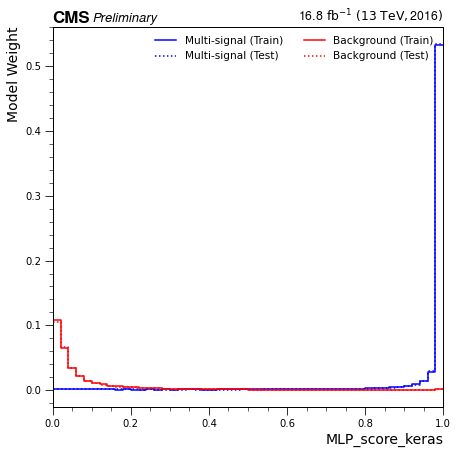

In [11]:
# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number

ana.step_plot(ax1, "MLP_score_keras", X_train[X_train.Label == 1], label=f"{plot_label} (Train)", color="blue", weight="modelWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "MLP_score_keras", X_test[X_test.Label == 1], label=f"{plot_label} (Test)", color="blue", weight="modelWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")
ana.step_plot(ax1, "MLP_score_keras", X_train[X_train.Label == 0], label="Background (Train)", color="red", weight="modelWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "MLP_score_keras", X_test[X_test.Label == 0], label="Background (Test)", color="red", weight="modelWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")

ana.labels(ax1, ylabel="Model Weight", xlabel="MLP_score_keras")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=False, legend_ncol=2, #ylim=[0, 1]
)
plt.savefig(f"{figures_path}/MLP_score_keras-modelWeight-{model_name}.png", dpi=200, facecolor='white')
plt.show()

# Plot  do discriminante usando evtWeight

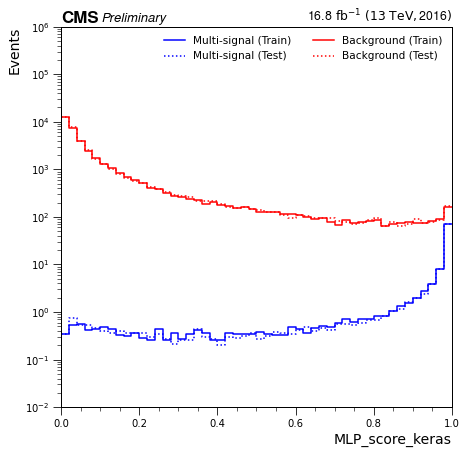

In [12]:
# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number

ana.step_plot(ax1, "MLP_score_keras", X_train[X_train.Label == 1], label=f"{plot_label} (Train)", color="blue", weight="evtWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "MLP_score_keras", X_test[X_test.Label == 1], label=f"{plot_label} (Test)", color="blue", weight="evtWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")
ana.step_plot(ax1, "MLP_score_keras", X_train[X_train.Label == 0], label="Background (Train)", color="red", weight="evtWeight", bins=np.linspace(0, 1, 51))
ana.step_plot(ax1, "MLP_score_keras", X_test[X_test.Label == 0], label="Background (Test)", color="red", weight="evtWeight", bins=np.linspace(0, 1, 51), linestyle="dotted")

ana.labels(ax1, ylabel="Events", xlabel="MLP_score_keras")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=True, legend_ncol=2, ylim=[1e-2, 1e6]
)
plt.savefig(f"{figures_path}/MLP_score_keras-evtWeight-{model_name}.png", dpi=200, facecolor='white')
plt.show()

# Converter o modelo para frugally-deep, formato para ser usando em C++

In [13]:
convert_to_fdeep(
    f"{models_path}/{model_name}-checkpoint.h5",
    f"{models_path}/{model_name}-checkpoint.json",
    False
)

loading ./models/hhdmAnalysis_deepJet_Regions/2016/MLP_multi_signal-checkpoint.h5
1/1 [==============================] - 0s 70ms/step
Forward pass took 0.126299 s.
1/1 [==============================] - 0s 25ms/step
Forward pass took 0.071513 s.
1/1 [==============================] - 0s 24ms/step
Forward pass took 0.070965 s.
Starting performance measurements.
1/1 [==============================] - 0s 24ms/step
Forward pass took 0.069177 s.
1/1 [==============================] - 0s 25ms/step
Forward pass took 0.073131 s.
1/1 [==============================] - 0s 25ms/step
Forward pass took 0.071435 s.
1/1 [==============================] - 0s 24ms/step
Forward pass took 0.068895 s.
1/1 [==============================] - 0s 24ms/step
Forward pass took 0.068636 s.
Forward pass took 0.07025479999999999 s on average.
Converting model architecture.
Converting model weights.
Done converting model weights.
Calculating model hash.
Model conversion finished.
writing ./models/hhdmAnalysis_deepJe